In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
%pip install wordcloud

In [4]:
%pip install kaggle

In [5]:
# Upload kaggle.json manually
from google.colab import files
files.upload()  # Upload kaggle.json

# Move it and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets download -d imuhammad/course-reviews-on-coursera


Dataset URL: https://www.kaggle.com/datasets/imuhammad/course-reviews-on-coursera
License(s): GPL-2.0
  0% 0.00/33.1M [00:00<?, ?B/s]
100% 33.1M/33.1M [00:00<00:00, 784MB/s]


In [7]:
!unzip course-reviews-on-coursera.zip

Archive:  course-reviews-on-coursera.zip
  inflating: Coursera_courses.csv    
  inflating: Coursera_reviews.csv    


### Exploratory Data Analysis

In [8]:
import pandas as pd

data = pd.read_csv('Coursera_reviews.csv', engine='python', quotechar='"')
display(data.head())

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [9]:
data.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [10]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['reviews' 'reviewers' 'date_reviews' 'rating' 'course_id']


In [11]:
data.shape


(1454711, 5)

In [12]:
#Check for null values

data.isnull().sum()

,0
reviews,153
reviewers,0
date_reviews,0
rating,0
course_id,0


In [13]:
#Getting the record where 'verified_reviews' is null

data[data['reviews'].isna() == True]

,reviews,reviewers,date_reviews,rating,course_id
73671,NaN,By Christopher L J,"Sep 26, 2020",5,computer-networking
73680,NaN,By Jerold K G,"Jun 10, 2020",5,computer-networking
95147,NaN,By t. d k,"Jun 27, 2020",5,ai-for-everyone
95152,NaN,By KODATHALA S V,"May 29, 2020",5,ai-for-everyone
95172,NaN,By t. d k,"Jun 27, 2020",5,ai-for-everyone
...,...,...,...,...,...
1422276,NaN,By Ritu K,"Aug 04, 2020",4,technical-support-fundamentals
1454669,NaN,By Christopher L J,"Sep 26, 2020",5,computer-networking
1454678,NaN,By Jerold K G,"Jun 10, 2020",5,computer-networking
1454691,NaN,By Christopher L J,"Sep 26, 2020",5,computer-networking


In [14]:
#We will drop the null record

data.dropna(inplace=True)

In [15]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (1454558, 5)


In [16]:
data.isnull().sum()

,0
reviews,0
reviewers,0
date_reviews,0
rating,0
course_id,0


In [17]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['reviews'].apply(len)

In [18]:
data.head()

,reviews,reviewers,date_reviews,rating,course_id,length
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,80


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [19]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['reviews']}")
print(f"Length of review : {len(data.iloc[10]['reviews'])}")
print(f"'length' column value : {data.iloc[10]['length']}")

'verified_reviews' column value: Great course, lectures were straight forward and easy to follow along.  The course provided all the information necessary to pass the CPI examination for certification.
Length of review : 168
'length' column value : 168


Datatypes of the features

In [20]:
data.dtypes

,0
reviews,object
reviewers,object
date_reviews,object
rating,int64
course_id,object
length,int64


* rating, length are integer values <br>
* reviewers, course_id and reviews are string values

In [21]:
len(data)

1454558

In [22]:

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    1146065
4     226666
3      48292
1      17350
2      16185
Name: count, dtype: int64


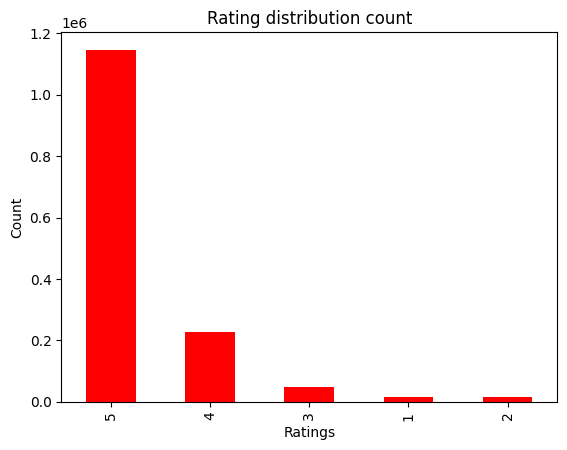

In [23]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [24]:
#Percentage

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    78.79
4    15.58
3     3.32
1     1.19
2     1.11
Name: count, dtype: float64


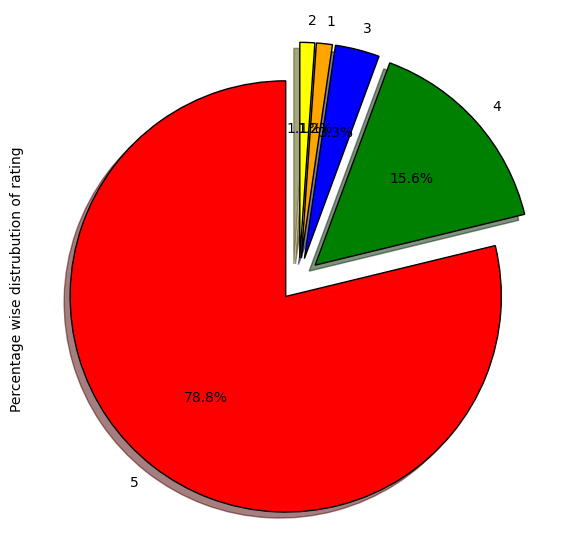

In [25]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

Create Feedback Column For ease


In [26]:


data['feedback'] = data['rating'].apply(lambda rating: 0 if rating in [1, 2] else 1)
data.head()

,reviews,reviewers,date_reviews,rating,course_id,length,feedback
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,346,1
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,245,1
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,224,1
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,83,1
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,80,1


### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [27]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    1421023
0      33535
Name: count, dtype: int64


feedback value = 0

In [28]:


review_0 = data[data['feedback'] == 0].iloc[1]['reviews']
print(review_0)

This course was horrible! The Content was very disoriented and unclear. Videos were distorted, and jumping from one topic to another. There was no sense of continuity. One can not say this was a course from Yale...


In [29]:


review_1 = data[data['feedback'] == 1].iloc[6]['reviews']
print(review_1)

Solid presentation all the way through. I really appreciated the intermittent questions that popped up to check on learning as well the regular (but not needless) quizzing. There was visuals such as charts / .ppt for those of us more visually inclined as well as a transcript below the video that followed along with the presentation!


In [30]:
review_3 = data[data['rating'] == 3]['reviews']
review_3

,reviews
225,Probably the best financial market course on c...
226,"From a knowledge perspective, I have learned a..."
227,Some parts of the course were informative. So...
228,"The course is not that challenging, it could b..."
229,It's more of a course for the people who have ...
...,...
1454297,some of the videos seemed to rush past some po...
1454298,Sir the course was really good but I think the...
1454299,"I liked Victor, but having to get 100% on the ..."
1454300,could put the subnetting etc into layman`s ter...


In [31]:
review_3 = data[data['rating'] == 3].iloc[1]['reviews']
review_4 = data[data['rating'] == 4].iloc[1]['reviews']
review_5 = data[data['rating'] == 5].iloc[1]['reviews']
print("Rating 3:",review_3)
print("Rating 4:",review_4)
print("Rating 5:",review_5)

Rating 3: From a knowledge perspective, I have learned a lot about financial markets, why various financial instruments exist, and the applications/implications of them. With all due respect to the lecturer, he was not very engaging and did not really provide emphasis on key concepts to make it stick. When explaining the concepts, he would "dilute" it with extra words or go off talking about "relevant" back story without wrapping it all up at the end. I had to review most of the videos a second time.
Rating 4: would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to be able to view any slides instructor is showing.
Rating 5: Probably the best certification course I've taken in this respect. The course is planned out carefully, and I believe gave me everything I needed to ace my exam the first time around. The trainer for the majority of the course w

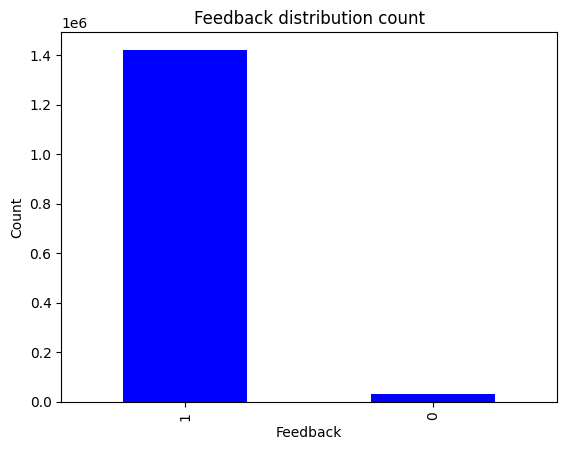

In [31]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [32]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    97.69
0     2.31
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

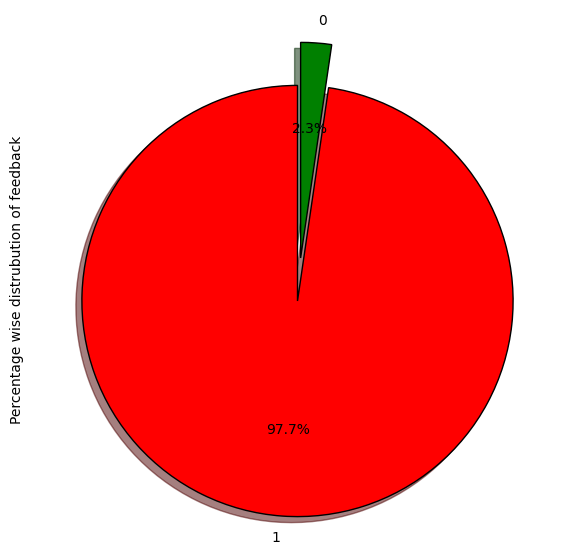

In [33]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [34]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,17350
2,16185


In [35]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,1146065
4,226666
3,48292


##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [36]:


print(f"Course id count: \n{data['course_id'].value_counts()}")

Course id count: 
course_id
python                                        45218
machine-learning                              35895
neural-networks-deep-learning                 35749
technical-support-fundamentals                35316
python-data                                   33543
                                              ...  
entrepreneurship-strategy                         6
curanderismo-plants                               6
entreprise-changement-climatique                  6
intro-to-healthcare                               6
building-modern-python-applications-on-aws        3
Name: count, Length: 604, dtype: int64


In [37]:

print(f"Distinct count of course_id: \n{data['course_id'].nunique()}")

Distinct count of course_id: 
604


In [38]:

print(f"Course ID count - percentage distribution: \n{round(data['course_id'].value_counts()/data.shape[0]*100,2)}")

Course ID count - percentage distribution: 
course_id
python                                        3.11
machine-learning                              2.47
neural-networks-deep-learning                 2.46
technical-support-fundamentals                2.43
python-data                                   2.31
                                              ... 
entrepreneurship-strategy                     0.00
curanderismo-plants                           0.00
entreprise-changement-climatique              0.00
intro-to-healthcare                           0.00
building-modern-python-applications-on-aws    0.00
Name: count, Length: 604, dtype: float64


In [39]:
data.groupby('course_id')['rating'].mean()

,rating
course_id,
aboriginal-education,4.604061
access-control-sscp,4.572519
accounting-analytics,4.426991
accounting-data-analytics-python,3.500000
actualizacion-manejo-diabetes-tipo-2,4.867052
...,...
womens-health-human-rights,4.894231
write-a-feature-length-screenplay-for-film-or-television,4.666667
write-your-first-novel,3.942308


### Analyzing 'Reviews' column

This column contains the textual review given by the student for a course.


In [40]:
data['length'].describe()

,length
count,1.454558e+06
mean,1.326026e+02
std,1.608138e+02
min,1.000000e+00
25%,3.600000e+01
50%,8.600000e+01
75%,1.720000e+02
max,7.837000e+03


Lengthwise mean rating

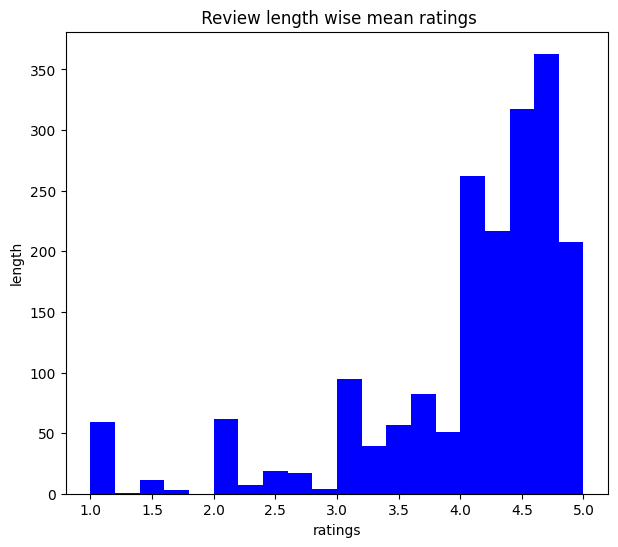

In [41]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [32]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.reviews)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import re
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS  # or define your own STOPWORDS list

# Assuming `data` already exists and has a 'reviews' column

# Process only the first 50000 rows
# data_subset = data.head(50000).copy()

def get_keywords(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in STOPWORDS]
    return ' '.join(text)

# Clean reviews for the subset
data['cleaned_reviews'] = data['reviews'].apply(get_keywords)

# Fit TF-IDF on the cleaned reviews of the subset
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(data['cleaned_reviews'])

# Extract top 5 keywords per row for the subset
def get_top_keywords(row):
    tfidf_scores = zip(tfidf.get_feature_names_out(), row.toarray()[0])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return ', '.join([word for word, score in sorted_scores[:5]])

data['keywords'] = [get_top_keywords(row) for row in tfidf_matrix]

# ✅ Save the TF-IDF model
with open("/content/drive/MyDrive/Datasets/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("TF-IDF model saved to tfidf_vectorizer.pkl")
print(data[['reviews', 'keywords']].head())

TF-IDF model saved to tfidf_vectorizer.pkl
                                             reviews  \
0  Pretty dry, but I was able to pass with just t...   
1  would be a better experience if the video and ...   
2  Information was perfect! The program itself wa...   
3  A few grammatical mistakes on test made me do ...   
4  Excellent course and the training provided was...   

                                            keywords  
0                   tests, pass, two, questions, far  
1               text, instructor, side, slides, view  
2       information, perfect, issues, watching, test  
3                     bad, test, take, made, ability  
4  training, detailed, provided, easy follow, follow  


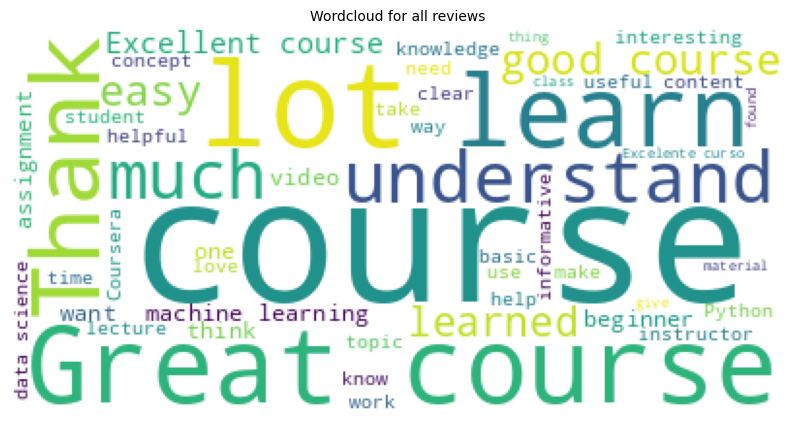

In [43]:
# Combine all reviews
reviews = " ".join([review for review in data['reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Unique words in each category


In [36]:
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['reviews']])
pos_reviews = pos_reviews.lower().split()

unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


KeyboardInterrupt: 

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [44]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [ ]:
cv = CountVectorizer(max_features = 5000)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus) # Removed .toarray()
y = data['feedback'].values

In [ ]:
#Saving the Count Vectorizer
import os

# Create the 'Models' directory if it doesn't exist
if not os.path.exists('Models'):
    os.makedirs('Models')

pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

**Load from pkl file
**

In [45]:
import pickle
import os

# Specify the path to your saved model file
cv_file_path = 'Models/countVectorizer.pkl' # You can change this to model_xgb.pkl if you want to load the XGBoost model

# Check if the model file exists
if os.path.exists(cv_file_path):
    # Load the model from the file
    with open(cv_file_path, 'rb') as f:
        cv = pickle.load(f)
    print(f"cv loaded successfully from {cv_file_path}")

else:
    print(f"cv file not found at {cv_file_path}. Please ensure you have saved the cv.")

cv loaded successfully from Models/countVectorizer.pkl


Checking the shape of X and y

In [47]:
X = cv.fit_transform(corpus) # Removed .toarray()
y = data['feedback'].values

In [48]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1454558, 5000)
y shape: (1454558,)


Splitting data into train and test set with 30% data with testing.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (1018190, 5000)
y train: (1018190,)
X test: (436368, 5000)
y test: (436368,)


In [60]:
X_test

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4779307 stored elements and shape (436368, 5000)>

In [ ]:
# Note: Checking max value on a sparse matrix is not directly comparable to a dense array.
# We can skip this check or use a different method if needed.
# print(f"X train max value: {X_train.max()}")
# print(f"X test max value: {X_test.max()}")

We'll scale X_train and X_test so that all values are between 0 and 1.

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

# MaxAbsScaler works with sparse matrices
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [ ]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

**Scaled image lod from .pkl**

In [50]:
import pickle
import os

# Specify the path to your saved model file
MinMaxScaler_file_path = 'Models/scaler.pkl' # You can change this to model_xgb.pkl if you want to load the XGBoost model

# Check if the model file exists
if os.path.exists(MinMaxScaler_file_path):
    # Load the model from the file
    with open(MinMaxScaler_file_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"Scaler loaded successfully from {MinMaxScaler_file_path}")

else:
    print(f"Scaler file not found at {MinMaxScaler_file_path}. Please ensure you have saved the scaler.")

Scaler loaded successfully from Models/scaler.pkl


In [54]:
# MaxAbsScaler works with sparse matrices
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [56]:
X_test

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4779307 stored elements and shape (436368, 5000)>

#### Random Forest

In [97]:
#Fitting scaled X_train and y_train on Random Forest Classifier
# RandomForestClassifier can handle sparse input
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

KeyboardInterrupt: 

In [ ]:
pickle.dump(model_rf, open('Models/model_rf.pkl', 'wb'))

RANDOM FORREST LOAD FROM .PKL

In [99]:
import pickle
import os

# Specify the path to your saved model file
model_file_path = 'Models/model_rf.pkl' # You can change this to model_xgb.pkl if you want to load the XGBoost model

# Check if the model file exists
if os.path.exists(model_file_path):
    # Load the model from the file
    with open(model_file_path, 'rb') as f:
        model_rf = pickle.load(f)
    print(f"model loaded successfully from {model_file_path}")

else:
    print(f"model file not found at {model_file_path}. Please ensure you have saved the model.")

model loaded successfully from Models/model_rf.pkl


In [100]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9983892986574215
Testing Accuracy : 0.9956275437245627


In [101]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [102]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

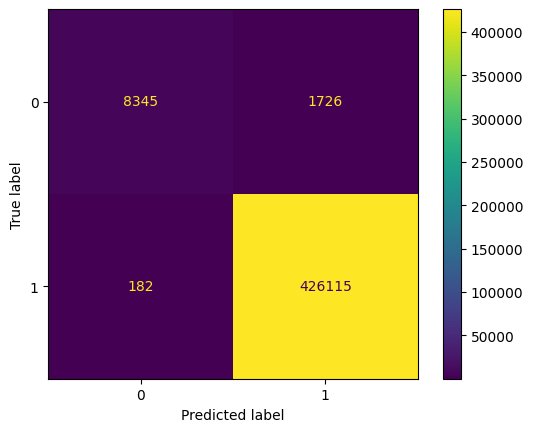

In [103]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [ ]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Applying grid search to get the optimal parameters on random forest

In [67]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [68]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

KeyboardInterrupt: 

In [ ]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

In [ ]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

#### XgBoost

In [92]:
# Calculate the ratio of negative to positive feedback for scale_pos_weight
neg_count = data['feedback'].value_counts()[0]
pos_count = data['feedback'].value_counts()[1]
scale_pos_weight_value = pos_count / neg_count # Ratio of positive to negative

# XGBoost can handle sparse input
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight_value)
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [87]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

In [93]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9800174820023768
Testing Accuracy : 0.9793454148791846


In [94]:
y_preds = model_xgb.predict(X_test)

In [95]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[   392   9679]
 [    84 426213]]


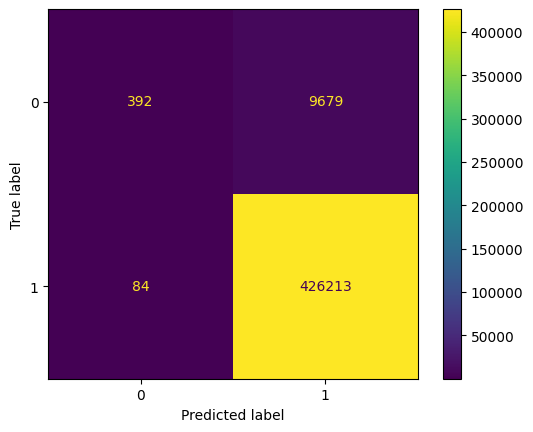

In [96]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

#### Decision Tree Classifier

In [75]:
model_dt = DecisionTreeClassifier(class_weight='balanced')
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [76]:
pickle.dump(model_dt, open('Models/model_destree.pkl', 'wb'))

In [77]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9983912629273515
Testing Accuracy : 0.9941471418619147


In [78]:
y_preds = model_dt.predict(X_test_scl) # Predict on scaled sparse test data

In [79]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  8558   1513]
 [  1041 425256]]


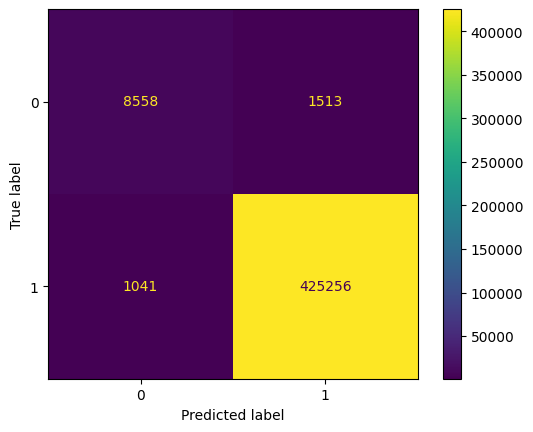

In [80]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

Good Confusion Matrix
False poitive and negatives are managed

PREDICT USING RANDOM FOREST MODEL

In [105]:


def predict_sentiment(comment, model, cv, scaler):

    stemmer = PorterStemmer()
    review = re.sub('[^a-zA-Z]', ' ', comment)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    cleaned_comment = ' '.join(review)
    comment_vector = cv.transform([cleaned_comment])

    comment_scaled = scaler.transform(comment_vector)


    prediction = model.predict(comment_scaled)


    sentiment = "Positive" if prediction[0] == 1 else "Negative"

    return sentiment, prediction[0]


new_comment = "The pedagogical architecture, while initially labyrinthine in its structural cadence, ultimately unfurled a tapestry of profound insights, each thread interwoven with a subtle yet pervasive luminescence that resonated deeply within the cognitive framework, fostering an almost alchemical transmutation of nascent understanding into a robust, internalized paradigm"
predicted_sentiment, prediction_value = predict_sentiment(new_comment, model_rf, cv, scaler)

print(f"The comment: '{new_comment}'")
print(f"Predicted sentiment: {predicted_sentiment} ({prediction_value})")

new_comment_2 = "Good but i could have done better because proff has horrible voice"
predicted_sentiment_2, prediction_value_2 = predict_sentiment(new_comment_2, model_rf, cv, scaler)

print(f"The comment: '{new_comment_2}'")
print(f"Predicted sentiment: {predicted_sentiment_2} ({prediction_value_2})")



print(f"USING DECISION TREE'{new_comment_2}'")

predicted_sentiment, prediction_value = predict_sentiment(new_comment, model_dt, cv, scaler)

print(f"The comment: '{new_comment}'")
print(f"Predicted sentiment: {predicted_sentiment} ({prediction_value})")

new_comment_2 = "Good but i could have done better because proff has horrible voice"
predicted_sentiment_2, prediction_value_2 = predict_sentiment(new_comment_2, model_dt, cv, scaler)

print(f"The comment: '{new_comment_2}'")
print(f"Predicted sentiment: {predicted_sentiment_2} ({prediction_value_2})")

The comment: 'The pedagogical architecture, while initially labyrinthine in its structural cadence, ultimately unfurled a tapestry of profound insights, each thread interwoven with a subtle yet pervasive luminescence that resonated deeply within the cognitive framework, fostering an almost alchemical transmutation of nascent understanding into a robust, internalized paradigm'
Predicted sentiment: Positive (1)
The comment: 'Good but i could have done better because proff has horrible voice'
Predicted sentiment: Negative (0)
USING DECISION TREE'Good but i could have done better because proff has horrible voice'
The comment: 'The pedagogical architecture, while initially labyrinthine in its structural cadence, ultimately unfurled a tapestry of profound insights, each thread interwoven with a subtle yet pervasive luminescence that resonated deeply within the cognitive framework, fostering an almost alchemical transmutation of nascent understanding into a robust, internalized paradigm'
Pred

Testing SVM for classification



*   But its not giving good precision
*   so not use



Training Accuracy : 0.982171303980593
Testing Accuracy : 0.9812864371356287
Confusion Matrix:
[[  2738   7333]
 [   833 425464]]


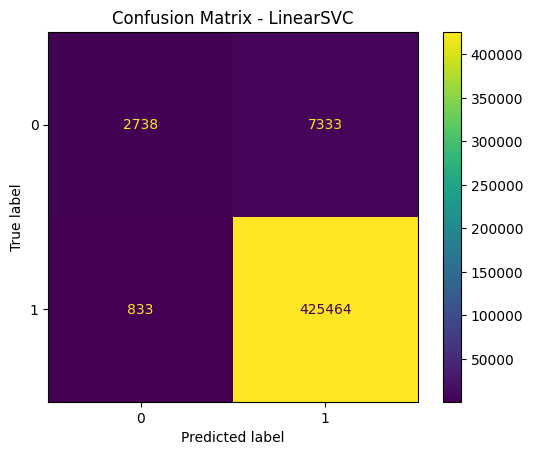

In [106]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize and train the LinearSVC model
# LinearSVC can handle sparse input
model_svm = LinearSVC(random_state=15)
model_svm.fit(X_train_scl, y_train)

# Evaluate the model
print("Training Accuracy :", model_svm.score(X_train_scl, y_train))
print("Testing Accuracy :", model_svm.score(X_test_scl, y_test))

# Predict on the test set
y_preds_svm = model_svm.predict(X_test_scl)

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_preds_svm)
print("Confusion Matrix:")
print(cm_svm)

# Display Confusion Matrix
cm_display_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=model_svm.classes_)
cm_display_svm.plot()
plt.title('Confusion Matrix - LinearSVC')
plt.show()

Keywords Extraction


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
# Ensure stopwords are downloaded if not already
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def extract_keywords_from_sentence(sentence, tfidf_vectorizer, num_keywords=5):
    """
    Extracts keywords from a single sentence using a fitted TF-IDF vectorizer.

    Args:
        sentence (str): The input sentence.
        tfidf_vectorizer: A fitted TfidfVectorizer object.
        num_keywords (int): The number of top keywords to extract.

    Returns:
        list: A list of the extracted keywords.
    """
    # Preprocess the sentence using the same cleaning steps as the training data
    text = re.sub('[^a-zA-Z]', ' ', sentence)
    text = text.lower().split()
    text = [word for word in text if word not in STOPWORDS]
    cleaned_sentence = ' '.join(text)

    # If the cleaned sentence is empty, return an empty list
    if not cleaned_sentence:
        return []

    # Vectorize the cleaned sentence using the *fitted* TF-IDF vectorizer
    # .transform expects an iterable, so pass the sentence in a list
    sentence_tfidf_matrix = tfidf_vectorizer.transform([cleaned_sentence])

    # Get the feature names (words) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF scores for the sentence
    # .toarray()[0] converts the sparse matrix row to a dense numpy array
    tfidf_scores = sentence_tfidf_matrix.toarray()[0]

    # Create a list of (word, score) tuples
    word_score_pairs = list(zip(feature_names, tfidf_scores))

    # Sort the word-score pairs by score in descending order
    sorted_scores = sorted(word_score_pairs, key=lambda x: x[1], reverse=True)

    # Extract the top keywords
    keywords = [word for word, score in sorted_scores[:num_keywords] if score > 0] # Only include words with score > 0

    return keywords

# Example usage:
# Ensure 'tfidf' (your fitted TfidfVectorizer) is available in your environment.
# If not, you need to run the cell that fits or loads the tfidf vectorizer first.

try:
    # Use the already fitted tfidf vectorizer
    example_sentence = "This was an excellent course with great content and helpful instructors."
    extracted_keywords = extract_keywords_from_sentence(example_sentence, tfidf)
    print(f"Keywords for sentence '{example_sentence}': {extracted_keywords}")

    example_sentence_2 = "The material was difficult to understand and the exercises were too challenging."
    extracted_keywords_2 = extract_keywords_from_sentence(example_sentence_2, tfidf)
    print(f"Keywords for sentence '{example_sentence_2}': {extracted_keywords_2}")

except NameError:
    print("Error: 'tfidf' (TfidfVectorizer) is not defined. Please run the cell that fits or loads the tfidf vectorizer.")
except Exception as e:
    print(f"An error occurred: {e}")

Keywords for sentence 'This was an excellent course with great content and helpful instructors.': ['course great', 'excellent course', 'content', 'helpful', 'excellent']
Keywords for sentence 'The material was difficult to understand and the exercises were too challenging.': ['difficult', 'challenging', 'exercises', 'material', 'understand']


In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
# Ensure stopwords are downloaded if not already
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

# Assume 'data' DataFrame is already loaded
# If not, uncomment the line below to load it
# data = pd.read_csv('Coursera_reviews.csv', engine='python', quotechar='"')

# Take the first 5000 reviews
reviews_subset = data['reviews'].head(3000).tolist()

# Preprocess the reviews subset for TF-IDF
# Assuming get_keywords function is available from previous steps
cleaned_reviews_subset = [get_keywords(review) for review in reviews_subset]

# Fit a TF-IDF vectorizer on this subset
# You might want to use the same parameters as your original tfidf vectorizer
tfidf_subset = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) # Using max_features 1000 as an example, adjust if needed
tfidf_matrix_subset = tfidf_subset.fit_transform(cleaned_reviews_subset)

# 1. List review-wise keywords
print("Review-wise Keywords (Top 5 per review):")
def get_top_keywords_for_review(row_index, tfidf_matrix, tfidf_vectorizer, num_keywords=30):
    tfidf_scores = zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[row_index])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    keywords = [word for word, score in sorted_scores[:num_keywords] if score > 0]
    return keywords

for i in range(len(reviews_subset)):
    keywords = get_top_keywords_for_review(i, tfidf_matrix_subset, tfidf_subset)
    # print(f"Review {i+1}: {reviews_subset[i][:100]}... - Keywords: {keywords}") # Print first 100 chars of review
    # print(f"Keywords: {keywords}") # Print first 100 chars of review


print("\n" + "="*50 + "\n") # Separator

# 2. Provide top 200 overall keywords from this subset
print("Top 200 Keywords from the first 5000 reviews:")
def get_top_n_overall_keywords(tfidf_matrix, tfidf_vectorizer, n=500):
    """
    Extracts the top N overall keywords from a TF-IDF matrix.

    Args:
        tfidf_matrix: The TF-IDF matrix.
        tfidf_vectorizer: The fitted TfidfVectorizer object used to create the matrix.
        n (int): The number of top keywords to extract.

    Returns:
        list: A list of the top N overall keywords.
    """
    # Calculate the sum of TF-IDF scores for each term across all reviews
    sum_tfidf = tfidf_matrix.sum(axis=0)

    # Get the feature names (words) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Create a list of (word, score) tuples
    word_score_pairs = list(zip(feature_names, sum_tfidf.flat))

    # Sort the word-score pairs by score in descending order
    sorted_scores = sorted(word_score_pairs, key=lambda x: x[1], reverse=True)

    # Extract the top N keywords
    top_keywords = [word for word, score in sorted_scores[:n]]

    return top_keywords

top_200_keywords_subset = get_top_n_overall_keywords(tfidf_matrix_subset, tfidf_subset, n=200)
print(top_200_keywords_subset)

Review-wise Keywords (Top 5 per review):


Top 200 Keywords from the first 5000 reviews:
['course', 'financial', 'finance', 'markets', 'shiller', 'professor', 'great', 'financial markets', 'good', 'knowledge', 'professor shiller', 'really', 'understand', 'lot', 'robert', 'learn', 'well', 'interesting', 'world', 'thank', 'robert shiller', 'would', 'concepts', 'also', 'excellent', 'market', 'prof', 'way', 'de', 'great course', 'coursera', 'amazing', 'much', 'learned', 'one', 'learning', 'many', 'topics', 'recommend', 'best', 'lectures', 'yale', 'like', 'useful', 'enjoyed', 'better', 'basic', 'time', 'engaging', 'experience', 'understanding', 'content', 'thanks', 'good course', 'things', 'informative', 'easy', 'get', 'new', 'financial market', 'highly', 'examples', 'curso', 'students', 'prof shiller', 'schiller', 'information', 'help', 'people', 'could', 'us', 'know', 'university', 'make', 'real', 'even', 'work', 'overview', 'helped', 'teaching', 'excellent course', 'life', 'material', 'w

# Task
Extract the top 200 relevant keywords from the first 5000 reviews in the provided CSV file, defining "relevant" as keywords with high TF-IDF scores, and list the keywords review by review.

## Define "relevant"

### Subtask:
Define "relevant" keywords based on TF-IDF scores.


## Calculate relevance scores

### Subtask:
Calculate relevance scores for each keyword based on TF-IDF scores from the fitted vectorizer on the subset of reviews.


**Reasoning**:
Calculate the sum of TF-IDF scores for each term across all reviews in the tfidf_matrix_subset, get the feature names, and create a sorted list of word-score pairs.



In [44]:
# Calculate the sum of TF-IDF scores for each term across all reviews
sum_tfidf = tfidf_matrix_subset.sum(axis=0)

# Get the feature names (words) from the vectorizer
feature_names = tfidf_subset.get_feature_names_out()

# Create a list of (word, score) tuples
word_score_pairs = list(zip(feature_names, sum_tfidf.flat))

# Sort the word-score pairs by score in descending order
sorted_scores = sorted(word_score_pairs, key=lambda x: x[1], reverse=True)

print("Top 20 word-score pairs based on summed TF-IDF scores:")
print(sorted_scores[:20])

Top 20 word-score pairs based on summed TF-IDF scores:
[('course', np.float64(232.7740238382579)), ('financial', np.float64(147.16744840428774)), ('finance', np.float64(129.4283989634201)), ('markets', np.float64(112.74191197637857)), ('shiller', np.float64(108.42700226173645)), ('professor', np.float64(105.33243143797031)), ('great', np.float64(103.86742835894287)), ('financial markets', np.float64(102.92700663023456)), ('good', np.float64(101.15689428522565)), ('knowledge', np.float64(69.17699884691991)), ('professor shiller', np.float64(63.1762823611372)), ('really', np.float64(62.93948810791067)), ('understand', np.float64(60.35568302955137)), ('lot', np.float64(59.01756584661423)), ('robert', np.float64(58.92824408983808)), ('learn', np.float64(58.43141965799058)), ('well', np.float64(56.75729769744904)), ('interesting', np.float64(55.947614421831446)), ('world', np.float64(55.34614060440002)), ('thank', np.float64(55.16884612403103))]


## Set a threshold or select top n

### Subtask:
Select the top 200 overall keywords from the subset of reviews based on their summed TF-IDF scores.


**Reasoning**:
Call the function to get the top 200 overall keywords and print the result.



In [45]:
top_200_overall_keywords = get_top_n_overall_keywords(tfidf_matrix_subset, tfidf_subset, n=200)
print(top_200_overall_keywords)

['course', 'financial', 'finance', 'markets', 'shiller', 'professor', 'great', 'financial markets', 'good', 'knowledge', 'professor shiller', 'really', 'understand', 'lot', 'robert', 'learn', 'well', 'interesting', 'world', 'thank', 'robert shiller', 'would', 'concepts', 'also', 'excellent', 'market', 'prof', 'way', 'de', 'great course', 'coursera', 'amazing', 'much', 'learned', 'one', 'learning', 'many', 'topics', 'recommend', 'best', 'lectures', 'yale', 'like', 'useful', 'enjoyed', 'better', 'basic', 'time', 'engaging', 'experience', 'understanding', 'content', 'thanks', 'good course', 'things', 'informative', 'easy', 'get', 'new', 'financial market', 'highly', 'examples', 'curso', 'students', 'prof shiller', 'schiller', 'information', 'help', 'people', 'could', 'us', 'know', 'university', 'make', 'real', 'even', 'work', 'overview', 'helped', 'teaching', 'excellent course', 'life', 'material', 'want', 'courses', 'take', 'teacher', 'different', 'opportunity', 'nice', 'professor robert

## Filter keywords

### Subtask:
Create a filtered list of keywords that meet the relevance criteria (the top 200 overall keywords identified in the previous step).


**Reasoning**:
Store the top 200 overall keywords in a variable and print the first 10 elements.



In [46]:
relevant_keywords = top_200_overall_keywords

print("First 10 relevant keywords:")
print(relevant_keywords[:10])

First 10 relevant keywords:
['course', 'financial', 'finance', 'markets', 'shiller', 'professor', 'great', 'financial markets', 'good', 'knowledge']


## Apply filtered keywords

### Subtask:
Apply the filtered list of relevant keywords for analysis or subsequent modeling steps.


**Reasoning**:
Apply the filtered list of relevant keywords for analysis or subsequent modeling steps by creating a new CountVectorizer with the relevant keywords as vocabulary and transforming the cleaned reviews to create keyword vectors.



In [ ]:
import re
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS  # or define your own STOPWORDS list

# Assuming `data` already exists and has a 'reviews' column

# Process only the first 50000 rows
# data_subset = data.head(50000).copy()

def get_keywords(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in STOPWORDS]
    return ' '.join(text)

# Clean reviews for the subset
data['cleaned_reviews'] = data['reviews'].apply(get_keywords)

# Fit TF-IDF on the cleaned reviews of the subset
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(data['cleaned_reviews'])

# Extract top 5 keywords per row for the subset
def get_top_keywords(row):
    tfidf_scores = zip(tfidf.get_feature_names_out(), row.toarray()[0])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return ', '.join([word for word, score in sorted_scores[:5]])

data['keywords'] = [get_top_keywords(row) for row in tfidf_matrix]

# ✅ Save the TF-IDF model
with open("/content/drive/MyDrive/Datasets/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("TF-IDF model saved to tfidf_vectorizer.pkl")
print(data[['reviews', 'keywords']].head())